In [67]:
import splice
import open_clip
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource
from matplotlib import pyplot as plt
import albumentations as A
DEVICE = 'cuda'

In [5]:
model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [24]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()
model = model.to(DEVICE)

In [2]:
vocabulary = splice.get_vocabulary('laion', 10_000) 

In [19]:
dl = DataLoader(vocabulary, batch_size=32)

In [25]:
concept_embs = torch.zeros(len(vocabulary), 768)
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    i = 0
    for x in bar:
        x = tokenizer(x)
        x = x.to(DEVICE)
        emb = model.encode_text(x)
        concept_embs[i:i + len(x)] = emb.cpu()
        i += len(x)
concept_embs.shape

Creating chip embeddings: 100%|███████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.88it/s]


torch.Size([10000, 768])

In [ ]:
# concept_embs /= concept_embs.norm(dim=-1, keepdim=True)


In [26]:
concepts = torch.nn.functional.normalize(concept_embs, dim=1)
concepts_mean = concepts.mean(dim=0)
concepts = concepts - concepts_mean
concepts = torch.nn.functional.normalize(concepts, dim=1)

In [27]:
img_embs = torch.load('data/skyscript_naip_MA_400_400.pt')
img_embs.shape

torch.Size([563379, 768])

In [28]:
img_mean = img_embs.mean(dim=0)

In [77]:
splicemodel = splice.SPLICE(img_mean, concepts, clip=model, device=DEVICE, return_weights=True)

In [43]:
rs = RasterioSource('data/m_3907506_ne_18_060_20191019.tif', channel_order=[0, 1, 2])

In [142]:
image = rs.get_chip(Box(0, 0, 800, 800).translate(3000, 1500))

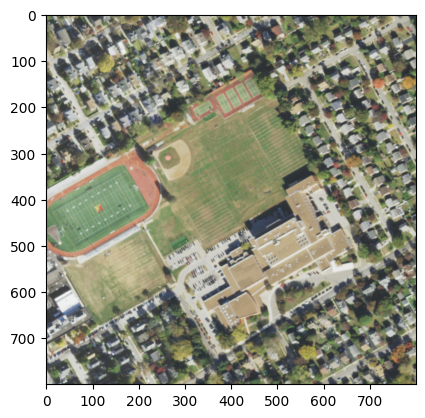

In [143]:
plt.imshow(image)
plt.show()

In [120]:
tf = A.Compose([
    A.Resize(224, 224),
    # A.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

In [144]:
with torch.inference_mode():
    x = tf(image=image)['image']
    x = x / 255.
    x = torch.from_numpy(x)
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE, dtype=torch.float32)
    sparse_weights = splicemodel.encode_image(x)

In [146]:
sparse_weights = sparse_weights.squeeze()

for weight_idx in torch.sort(sparse_weights, descending=True)[1][:20]:
    print(f'{vocabulary[weight_idx]}: {sparse_weights[weight_idx]}')

turf: 0.16702087223529816
academy: 0.1506529152393341
baths: 0.14275017380714417
pe: 0.11904092878103256
textbook: 0.11827417463064194
linking: 0.11778547614812851
delivery: 0.11707062274217606
surveillance: 0.11574400216341019
varsity: 0.11157937347888947
montage: 0.11151287704706192
removing: 0.10628823190927505
western: 0.104046531021595
os: 0.1020507961511612
tool: 0.1019056960940361
lights: 0.10032016783952713
pineapple: 0.09924186766147614
mosaic: 0.09814996272325516
district: 0.09685584902763367
featured: 0.09671349823474884
che: 0.09638659656047821
